<h1> Fraudulent Job Postings Detection </h1>

<h3> Objective </h3>
<p>Enhance online job search safety utilizing data science and machine learning. By detecting and mitigating fraudulent job postings, we can minimize harm, build user trust and enhance platform reliability. Success is gauged through a significant increase in accuracy for identifying potential hazards in fraudulent job listings, previously ~85%. </p>


In [1]:
'''Import preprocessing libraries'''
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import nltk 

In [2]:
'''Load in dataset'''
df = pd.read_csv('fake_job_postings.csv')
df.head()

job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

<h3>Exploratory Data Analysis

In [3]:
'''Check data shape'''
df.shape

(17880, 18)

In [4]:
'''Check target balance'''
df['fraudulent'].value_counts(normalize=True)*100

0    95.1566
1     4.8434
Name: fraudulent, dtype: float64

In [5]:
'''Check column info'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [6]:
'''Check for null values'''
df.isna().sum().sort_values(ascending=False)

salary_range           15012
department             11547
required_education      8105
benefits                7210
required_experience     7050
function                6455
industry                4903
employment_type         3471
company_profile         3308
requirements            2695
location                 346
description                1
job_id                     0
telecommuting              0
has_questions              0
has_company_logo           0
title                      0
fraudulent                 0
dtype: int64

<h3> Data Preprocessing

In [7]:
'''Fill null values'''
job = df
job.fillna({'salary_range'       : 'no salary range.', 
               'department'         : 'no department.', 
               'required_education' : 'no required education.',
               'benefits'           : 'benefits not given.', 
               'required_experience': 'no required experience.',
               'function'           : 'no function.', 
               'industry'           : 'industry not given.', 
               'employment_type'    : 'no employment type.', 
               'company_profile'    : 'no company profile.', 
               'requirements'       : 'no requirements.', 
               'location'           : 'location not given.', 
               'description'        : 'no description.'}, 
              inplace=True)
job.isna().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [8]:
'''Check numerical features and correlation to fraud'''
for feat in job.select_dtypes('int').columns.tolist():
    if feat != 'fraudulent':
        print(f'{feat}:')
        print(job[feat].value_counts(), '\n')

job_id:
1        1
11919    1
11925    1
11924    1
11923    1
        ..
5966     1
5967     1
5968     1
5969     1
17880    1
Name: job_id, Length: 17880, dtype: int64 

telecommuting:
0    17113
1      767
Name: telecommuting, dtype: int64 

has_company_logo:
1    14220
0     3660
Name: has_company_logo, dtype: int64 

has_questions:
0    9088
1    8792
Name: has_questions, dtype: int64 



In [9]:
'''Map all numerical features as corresponding text'''
job.replace({'telecommuting'   : {0 : 'no telecommuting.', 1: 'has telecommuting.'}, 
                'has_company_logo': {0: 'no company logo.', 1: 'has company logo.'}, 
                'has_questions'   : {0: 'no questions.', 1: 'has questions.'}}, 
               inplace=True)

In [10]:
'''Keep only necessary columns'''
job = job[['telecommuting', 'has_company_logo', 'has_questions']]
job.head()

telecommuting   has_company_logo   has_questions
0  no telecommuting.  has company logo.   no questions.
1  no telecommuting.  has company logo.   no questions.
2  no telecommuting.  has company logo.   no questions.
3  no telecommuting.  has company logo.   no questions.
4  no telecommuting.  has company logo.  has questions.

In [11]:
'''Merge back into original dataframe'''
df[['telecommuting', 'has_company_logo', 'has_questions']] = job[['telecommuting', 'has_company_logo', 'has_questions']]
df.head()

job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

       department      salary_range  \
0       Marketing  no salary range.   
1         Success  no salary range.   
2  no department.  no salary range.   
3           Sales  no salary range.   
4  no department.  no salary range.   

                                     company_profile  \
0  We're Food52, and we've created a groundbreaki...   
1  90 Seconds, the worlds Cloud Video Production ...   
2  Valor Services provides Workforce Solutions th...   
3  Our passion for improving quality of life thro...   
4  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits      telecommuting  \
0                                benefits not given.  no telecommuting.   
1  What you will get from usThrough being part of...  no telecommuting.   
2                                benefits not given.  no telecommuting.   
3  Our culture is anything but corporate—we have ...  no telecommuting.   
4                              Full Benefits Offered  no telecommuting.   

    has_company_logo   has_questions      employment_type  \
0  has company logo.   no questions.                Other   
1  has company logo.   no questions.            Full-time   
2  has company logo.   no questions.  no employment type.   
3  has company logo.   no questions.            Full-time   
4  has company logo.  has questions.            Full-time   

       required_experience      required_education                   industry  \
0               Internship  no required education.        industry not given.   
1           Not Applicable  no required education.  Marketing and Advertising   
2  no required experience.  no required education.        industry not given.   
3         Mid-Senior level       Bachelor's Degree          Computer Software   
4         Mid-Senior level       Bachelor's Degree     Hospital & Health Care   

               function  fraudulent  
0             Marketing           0  
1      Customer Service           0  
2          no function.           0  
3                 Sales           0  
4  Health Care Provider           0

In [12]:
'''Combine all text into a single feature'''
full_text_df = pd.DataFrame({'full_desc': df.apply(lambda row: ' '.join(row.values[1: -1]), axis=1), 
                       'fraud'    : df['fraudulent']})
full_text_df.head()

full_desc  fraud
0  Marketing Intern US, NY, New York Marketing no...      0
1  Customer Service - Cloud Video Production NZ, ...      0
2  Commissioning Machinery Assistant (CMA) US, IA...      0
3  Account Executive - Washington DC US, DC, Wash...      0
4  Bill Review Manager US, FL, Fort Worth no depa...      0

<h3>Text Preprocessing

In [13]:
'''Preprocessing function'''
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')

def preprocess(text):
    tokens = tokenizer.tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    cleansed = [word.lower() for word in lemmatized if word not in stopwords]
    string = ' '.join(cleansed)
    return string

In [14]:
'''Call function on text'''
full_text_df['cleansed'] = full_text_df['full_desc'].apply(preprocess)
full_text_df.head()

full_desc  fraud  \
0  Marketing Intern US, NY, New York Marketing no...      0   
1  Customer Service - Cloud Video Production NZ, ...      0   
2  Commissioning Machinery Assistant (CMA) US, IA...      0   
3  Account Executive - Washington DC US, DC, Wash...      0   
4  Bill Review Manager US, FL, Fort Worth no depa...      0   

                                            cleansed  
0  marketing intern us ny new york marketing sala...  
1  customer service cloud video production nz auc...  
2  commissioning machinery assistant cma us ia we...  
3  account executive washington dc us dc washingt...  
4  bill review manager us fl fort worth departmen...

<h3> Model Preprocessing

In [15]:
'''Train test split'''
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(full_text_df.cleansed, full_text_df.fraud, test_size=0.2, random_state=42, stratify=full_text_df.fraud)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14304,), (3576,), (14304,), (3576,))

<h3>Machine Learning

In [16]:
'''TFIDF Approach
Model Pipeline:
    Count Vectorizer
    TFIDF
    SMOTE
    Prediction'''
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

clf = Pipeline([
  ('vect', CountVectorizer()),
   ('tfidf', TfidfTransformer()),
   ('smote', SMOTE(random_state=12)),
   ('mnb', MultinomialNB(alpha =0.1))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [17]:
np.unique(y_pred)

array([0, 1], dtype=int64)

In [18]:
'''Model Evaluation'''
from sklearn.metrics import classification_report

nbc_acc = classification_report(y_test, y_pred)
print(nbc_acc)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.79      0.89      0.84       173

    accuracy                           0.98      3576
   macro avg       0.89      0.94      0.91      3576
weighted avg       0.98      0.98      0.98      3576



Preferred to do vectorize -> smote -> train test split -> model training / prediction.

<h3> Deep Learning

In [19]:
'''Convert series back to dataframe'''
X_train_df = X_train.to_frame()
X_test_df = X_test.to_frame()
X_train_df.head()

cleansed
7530   contact center representatives us va virginia ...
129    customer service associate us tx dallas depart...
4640   automated test analyst nz auckland permanent s...
402    inside sales professional omaha us ne omaha de...
13218  content marketing seo manager us ca los angele...

In [20]:
'''Import DL libraries'''
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
'''Text vectorization using tensorflow'''
sequence_length = 1000 # based on the max number of words of a job posting in training data 
vocab_size = 50000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='[oov]')
tokenizer.fit_on_texts(X_train_df['cleansed'])
len(tokenizer.word_counts)

91427

In [37]:
'''Token indexing'''
X_train_clean_indexed = tokenizer.texts_to_sequences(X_train_df['cleansed'])
X_train_clean_indexed

[[345,
  440,
  2272,
  37,
  1305,
  2140,
  1294,
  35,
  18,
  26,
  752,
  285,
  519,
  422,
  411,
  3193,
  1338,
  932,
  1573,
  2058,
  299,
  3409,
  208,
  1091,
  535,
  1409,
  752,
  377,
  89,
  202,
  1813,
  257,
  299,
  285,
  695,
  752,
  1733,
  377,
  202,
  1813,
  257,
  1384,
  1689,
  4,
  1367,
  591,
  512,
  648,
  1020,
  257,
  156,
  1029,
  1029,
  1029,
  1215,
  41,
  181,
  2768,
  2856,
  181,
  1020,
  257,
  15,
  9,
  57,
  128,
  229,
  39,
  792,
  445,
  175,
  352,
  200,
  114,
  1301,
  445,
  175,
  150,
  19,
  2159,
  184,
  455,
  70,
  2165,
  455,
  2314,
  231,
  1060,
  1061,
  757,
  87,
  3142,
  39,
  128,
  132,
  373,
  122,
  538,
  2128,
  839,
  135,
  2,
  624,
  352,
  200,
  114,
  67,
  880,
  1096,
  186,
  3143,
  460,
  138,
  5,
  185,
  2460,
  57,
  1981,
  1150,
  1679,
  2938,
  430,
  752,
  285,
  2,
  433,
  2140,
  1294,
  1305,
  7,
  15,
  83,
  9,
  57,
  236,
  345,
  440,
  2272,
  4,
  68,
  678,
  28

In [41]:
'''Text Vectorization'''
X_train_clean_vect = pad_sequences(X_train_clean_indexed, 
                                   maxlen=sequence_length,
                                   padding='post', 
                                   truncating='post')
X_train_clean_vect.shape, X_train_clean_vect.max()

((14304, 1000), 49999)

In [42]:
'''Text Vectorization - test'''
X_test_clean_indexed = tokenizer.texts_to_sequences(X_test_df['cleansed'])
X_test_clean_vect = pad_sequences(X_test_clean_indexed, 
                                  maxlen=sequence_length,
                                  padding='post', 
                                  truncating='post')

In [25]:
'''Build NN'''

nn = Sequential([
    tf.keras.Input(shape=(sequence_length,), name='input'),
    Embedding(input_dim=vocab_size, 
              output_dim=32, 
              name='embedding'),
    Bidirectional(LSTM(units=20,
                       return_sequences=True), 
                  name='bi-LSTM-1'),
    Bidirectional(LSTM(units=10,
                       return_sequences=False), 
                  name='bi-LSTM-2'),
    Dense(16, activation='relu', name='Dense'),
    Dense(1, activation = 'sigmoid',
          name = 'Output')
])

In [54]:
'''Compile model'''
nn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          1600000   
                                                                 
 bi-LSTM-1 (Bidirectional)   (None, 1000, 40)          8480      
                                                                 
 bi-LSTM-2 (Bidirectional)   (None, 20)                4080      
                                                                 
 Dense (Dense)               (None, 16)                336       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 1612913 (6.15 MB)
Trainable params: 1612913 (6.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
'''Train model'''
history = nn.fit(
    X_train_clean_vect,
    y_train,
    epochs=3,
)

Epoch 1/3
447/447 [==============================] - 239s 522ms/step - loss: 0.1303 - accuracy: 0.9673
Epoch 2/3
447/447 [==============================] - 274s 613ms/step - loss: 0.0284 - accuracy: 0.9913
Epoch 3/3
447/447 [==============================] - 264s 591ms/step - loss: 0.0120 - accuracy: 0.9965


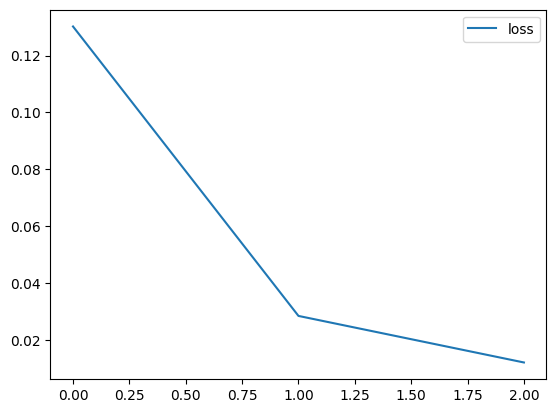

In [61]:
'''Plot loss over training'''
pd.DataFrame(history.history)[['loss']].plot();

In [60]:
'''Predict and evaluate'''
nn_pred = nn.predict(X_test_clean_vect)
nn_pred = (nn_pred > 0.5).astype(int)
nn_acc = classification_report(y_test, nn_pred)
print(nn_acc)

112/112 [==============================] - 15s 118ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.97      0.77      0.86       173

    accuracy                           0.99      3576
   macro avg       0.98      0.89      0.93      3576
weighted avg       0.99      0.99      0.99      3576

